# What the heck is a collapsed gibbs sampler?

Rather than going through sampling we try to use the magic of conjugacy to update our beliefs about each of the distributions analytically.

Its easier to see in code.

(array([ 1.,  6., 14., 19., 12., 12., 19.,  5.,  7.,  5.]),
 array([0.77659685, 1.23725164, 1.69790643, 2.15856123, 2.61921602,
        3.07987081, 3.5405256 , 4.0011804 , 4.46183519, 4.92248998,
        5.38314477]),
 <BarContainer object of 10 artists>)

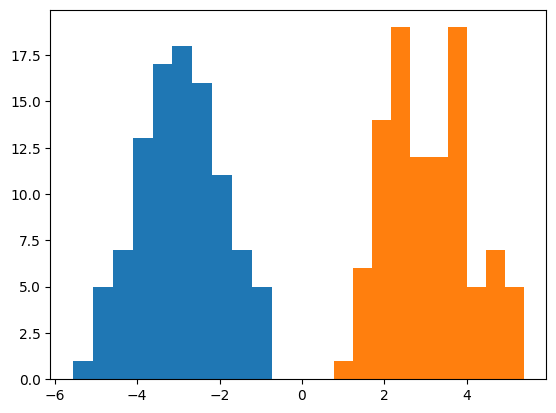

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some synthetic 1D data
np.random.seed(0)
X = np.concatenate([
    np.random.normal(-3, 1, size=100),
    np.random.normal(3, 1, size=100)
])

# Showing that we created two univariate distributions.
plt.hist(X[:100])
plt.hist(X[100:])

# Log Predictive

In this case, we see what the probability would be *if* we did an update to the parameters of our distribution. This is sort of slick, because we get to quickly update our distribution before checking if that will lead to some update in the distribution.

In [146]:
def log_predictive(x_new, x_k, mu0=0, tau2=1, sigma2=1):
    """Log predictive probability of x_new given data in cluster k"""
    # We have our initial parameters
    n = len(x_k)
    if n == 0:
        # We assign some uninformative priors (sigma2 and tau2 both equal to 1), and we get some prior estimate of the variance (2).
        var = sigma2 + tau2
        
        # This is the log likelihood of our new data point, given our prior distribution assumptions.
        return -0.5 * np.log(2 * np.pi * var) - 0.5 * x_new**2 / var

    else:
        # When we have data, we can update our parameters.
        # Empirical mean.
        x_bar = np.mean(x_k)
        # This is an update formula.

        # https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions
        var = sigma2 * (1 + 1 / (n + sigma2 / tau2))
        mean = (n * x_bar + (sigma2 / tau2) * mu0) / (n + sigma2 / tau2)
        return -0.5 * np.log(2 * np.pi * var) - 0.5 * (x_new - mean)**2 / var



# Collapsed Gibbs Sampler

Rather than doing some full update by re-estimating all the parameters, we can used a closed form update (thanks math god), and we get really quick estimations of each of the classes, and can estimate which of these groups they should belong to.

Even under model misspecification, this can be very robust, for example, our choice of alpha is typically informed by the number of expected classes we are going to see in our data:

expected_number_of_classes = alpha * log(N)

so here, we are estimating that we have 100 classes, but look how butifyl it looks.

In [162]:
from tqdm import tqdm
from collections import defaultdict

alpha = 100.0 / len(X)

clusters = defaultdict(list)
assignments = np.array([-1] * len(X))  # -1 means unassigned

for epoch in tqdm(range(100)):
    # for each element in X
    for ix, x_new in enumerate(X):
        # save old assignments
        k_old = assignments[ix]
        assignments[ix] = -1 # reset assignment

        if k_old != -1:  # don't try to remove if it's unassigned
            clusters[k_old].remove(ix)
            if len(clusters[k_old]) == 0:
                del clusters[k_old]


        if len(clusters[k_old]) == 0:
            del clusters[k_old]

        # question: which cluster should we assign this new data point to?
        labels = list(clusters.keys()) + ['new']
        log_probs = []

        for k in labels:
            if k == 'new':
                # If we are assigning to a new cluster, we use the prior.
                log_prob = log_predictive(x_new, np.array([])) + np.log(alpha)
            else:
                # Otherwise, we use the existing cluster.
                log_prob = log_predictive(x_new, np.array(X[clusters[k]])) + np.log(len(clusters[k]))

            log_probs.append(log_prob)

        probs = np.exp(log_probs - np.max(log_probs))
        probs /= np.sum(probs)

        k_new = np.random.choice(labels, p=probs)

        if k_new == 'new':
            k_new = max(clusters.keys(), default=-1) + 1

        assignments[ix] = k_new
        clusters[int(k_new)].append(ix)

100%|██████████| 100/100 [00:00<00:00, 127.18it/s]


Nearly separation of clusters each time (if you run this several times, you'll get variations on the same theme, two main distributions).

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

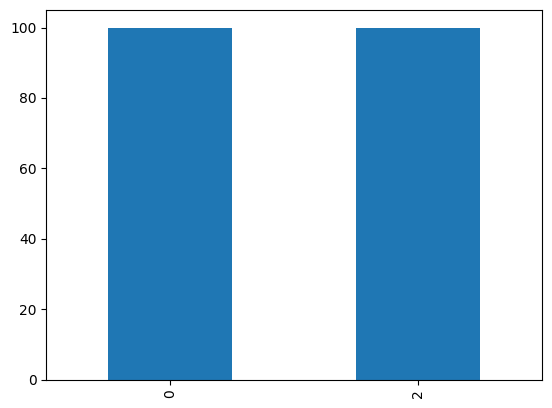

In [163]:
pd.Series(assignments).value_counts().sort_index().plot(kind='bar')
assignments